<a href="https://colab.research.google.com/github/shubhambadaya/toxic_comment_classification_using_lstm/blob/main/lstm_toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
#copy kaggle json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/


In [ ]:
!kaggle -v

Kaggle API 1.5.4


In [ ]:
#download toxic dataset
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 76% 20.0M/26.3M [00:00<00:00, 65.2MB/s]
100% 26.3M/26.3M [00:00<00:00, 103MB/s] 
 90% 21.0M/23.4M [00:00<00:00, 66.0MB/s]
100% 23.4M/23.4M [00:00<00:00, 115MB/s] 
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 94.9MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 98.1MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!head train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"
"0000997932d777bf","Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
"000103f0d9cfb60f","D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
"000113f07ec002fd","Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
"0001b41b1c6bb37e","""
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents""""  -I think the refere

In [ ]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [ ]:
# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


load in pre-trained word vectors



In [ ]:
print('Loading word vectors...')
word2vec = {}
#/content/drive/MyDrive/glove.6B.100d.txt
with open(os.path.join('/content/drive/MyDrive/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


prepare text samples and their labels

In [ ]:
print('Loading in comments...')

train = pd.read_csv("../content/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [ ]:
print(sentences.shape)
print(targets.shape)

(159571,)
(159571, 6)


In [ ]:
print("max sequence length:", max(len(s) for s in sentences))
print("min sequence length:", min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 5000
min sequence length: 6
median sequence length: 205


In [ ]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()


print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [ ]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [ ]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Building model...
Training model...
Epoch 1/10
998/998 [==============================] - 28s 14ms/step - loss: 0.0839 - accuracy: 0.9758 - val_loss: 0.0771 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0676 - accuracy: 0.9927 - val_loss: 0.0892 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0629 - accuracy: 0.9924 - val_loss: 0.0756 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0597 - accuracy: 0.9930 - val_loss: 0.0700 - val_accuracy: 0.9848
Epoch 5/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0572 - accuracy: 0.9935 - val_loss: 0.0716 - val_accuracy: 0.9938
Epoch 6/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0553 - accuracy: 0.9937 - val_loss: 0.0767 - val_accuracy: 0.9937
Epoch 7/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0540 - accuracy: 0.993

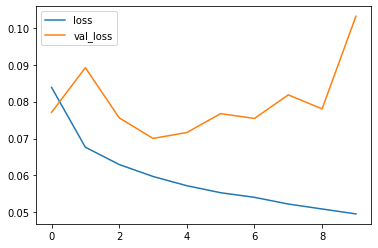

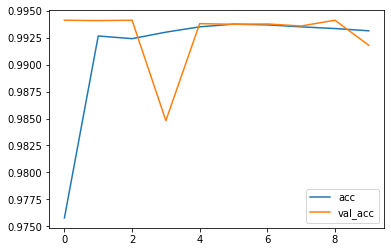

0.975805863700396


In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))


###embedding layer without pretrained word embedding

In [ ]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  #weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  #trainable=False
)

In [ ]:
print('Building model without pretrained word embeddings')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Building model without pretrained word embeddings
Training model...
Epoch 1/10
998/998 [==============================] - 18s 17ms/step - loss: 0.0826 - accuracy: 0.9852 - val_loss: 0.0738 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 17s 17ms/step - loss: 0.0625 - accuracy: 0.9936 - val_loss: 0.1003 - val_accuracy: 0.9940
Epoch 3/10
998/998 [==============================] - 17s 17ms/step - loss: 0.0590 - accuracy: 0.9933 - val_loss: 0.0650 - val_accuracy: 0.9934
Epoch 4/10
998/998 [==============================] - 17s 17ms/step - loss: 0.0558 - accuracy: 0.9931 - val_loss: 0.0640 - val_accuracy: 0.9922
Epoch 5/10
998/998 [==============================] - 17s 17ms/step - loss: 0.0529 - accuracy: 0.9929 - val_loss: 0.0673 - val_accuracy: 0.9924
Epoch 6/10
998/998 [==============================] - 17s 17ms/step - loss: 0.0500 - accuracy: 0.9931 - val_loss: 0.0732 - val_accuracy: 0.9938
Epoch 7/10
998/998 [==============================] - 17s 17ms/step 

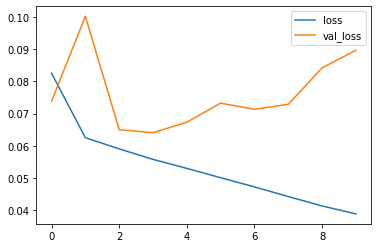

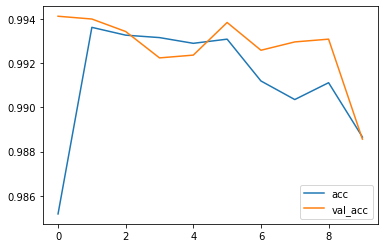

0.9791297567686225


In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))